# Project Vehicle Detection

In [7]:
# Import libraries

import numpy as np
import cv2
import pickle
import glob
import time
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

/home/trevisan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/trevisan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Example of Histogram Feature Extraction

To find Cars in images, we'll get information related to color, saturation, and luminosity for each car and non car example, to get this information, we'll extract a histogram and use it to create a feature vector.

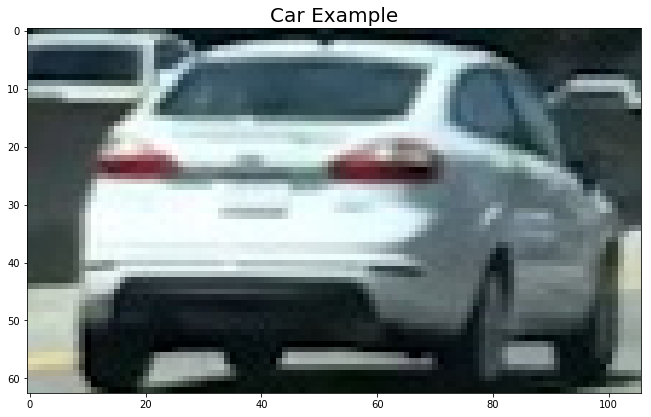

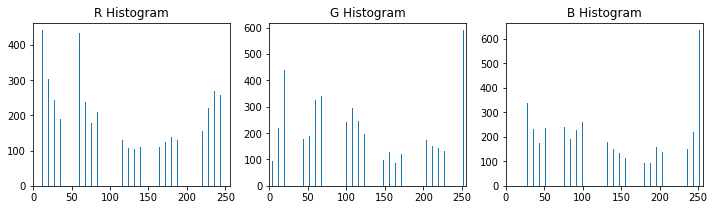

In [8]:
# Read in the image
image = mpimg.imread('cutouts/cutout1.jpg')

# Take histograms in R, G, and B
rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts

plt.figure(figsize=(11,11))
plt.imshow(image)
plt.title('Car Example', fontsize=(20))
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

### Converting a Image in a Feature Vector

Define a function to compute color histogram features, given a olor_space flag as 3-letter all caps string
like 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'.

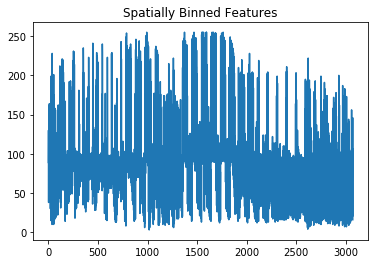

In [3]:
image = mpimg.imread('cutouts/cutout1.jpg')

# Define a Bin Spatial Function
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Test the function
feature_vec = bin_spatial(image, color_space='HLS', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

### Importing Data

To feed our algorithm we have two option of dataset: a Small used to test and tune the algorithm, and a full to create a more robust classifier.

Data can be downloaded at,

**Small Dataset:** 

[Vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip)
[Non-Vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip)

**Full Dataset:**

[Vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
[Non-Vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

In [4]:
# Choose between Small or Full Dataset
Small_dataset = False
Full_dataset = True

# Verify option
if Small_dataset == True:
    # Import Small Dataset
    images = glob.glob('vehicles_small/*/*.jpeg')
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
else:
    # Import Full Dataset
    cars = glob.glob('vehicles/Cars/*/*.png')
    notcars = glob.glob('vehicles/Not_Cars/*/*.png')

print("Imported Data has: \n")
print("", len(cars)," examples of Cars \n", len(notcars), " examples of Non Cars")

Imported Data has: 

 8792  examples of Cars 
 8968  examples of Non Cars


### Visualizing Samples

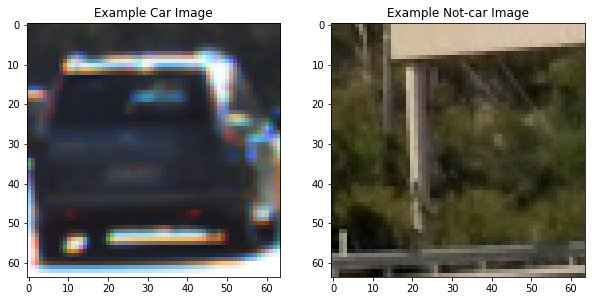

In [109]:
# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


### Histogram Oriented Gradient (HOG)

Color Histograms do not capture information about shape of objetcs, so we compute a [Histogram of Oriented Gradient](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) to extract this information and like we did with Color Histogram use it as feature to feed our classifier.

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Extract features and Hog Image
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        # Extract features and Hog Image
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


In [114]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


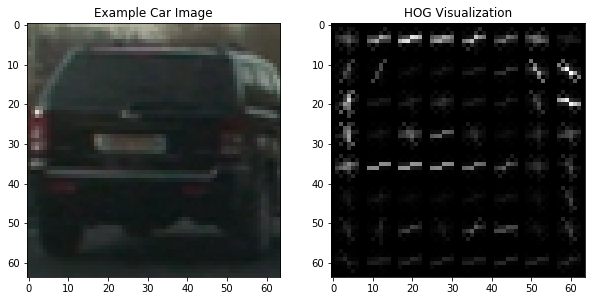

In [115]:
# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


### Combine and Normalize Features

To feed our classifier we need the most possible number of feature, in this project we'll use 3 types:

* **Spatial Binning of Color:** which allow us perform a template match. This is not the best way because don't it takes into account changes of shape or variations, but still usefull to improve our algorithm.


* **Color Histogram :** Capture signature of color, saturation and luminosity of car and non car examples.


* **Histogram of Oriented Gradient:** Capture information about shape of car and non car examples.


To use all this features we'll define functions to extract each feature and one function to merge in one feature vector for image.

In [9]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [10]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Combine and Normalize Features (Example)

In the next line a example of combine and normalize features using only bin_spatial an color_hist functions. 

In [11]:
# Define a function to extract features from a list of images

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


In [12]:
# Extract Features
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


17760


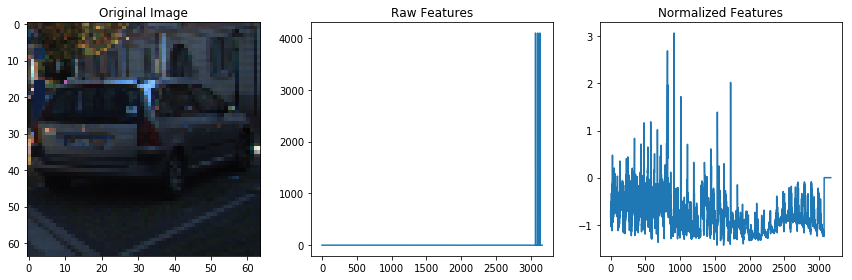

In [13]:
# Combine Features
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    
    # Normalize Features    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    print(len(scaled_X))
else: 
    print('Your function only returns empty feature vectors...')

## Define Single Image and Search Windows Functions

Instead extract feature function, now we'll define a function to extract the 3 types of features from a single image and concatenate this features just one feature vector.

After that, we'll define a function that gives a list of windows looking for cars in each of them.

In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

# Building a Classifier

* First define parameters
* Extratct Features
* Normalize Features
* Create a Train Dataset with Features (X) and Labels (y)
* Shufle the data
* Train a Classifier
* Score Classifier Performance

### Parameter to Feature Extraction

In [117]:
#Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, None] # Min and max in y to search in slide_window()


### Performe Feature Extraction

In [118]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [119]:
# Extract Features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

### Normalize Features, Create Train Set with Labels and Shufle the Data

In [20]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9732


### Train a Classifier and Mesure Performance

To this project Suppor Vector Machine works well, I used [GridSearCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find given a list of parameters the best combination, use [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to score then. 

In [22]:
# Use a linear SVC 
parameters = {'kernel':['linear'], 'C':[0.1, 0.2, 0.3, 0.5, 1]}
svr = SVC()
svc = GridSearchCV(svr, parameters)

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# Print GridSearchCV best Parameters
print("Support Vector Machine Best Parameters: ")
print("Kernel=", svc.best_params_['kernel'], ", and C=", svc.best_params_['C'])


3248.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
Support Vector Machine Best Parameters: 
Kernel= linear , and C= 0.1


In [23]:
# Save the Model
with open('model.pkl', 'wb') as fout:
  pickle.dump(svc, fout)

with open('model.pkl', 'rb') as fin:
  model = pickle.load(fin)

# Sliding Windows

To find cars in each image or video frame, we'll implement a function to extract small portions (windows) of original image, using given parameters we'll able to define how windows will "sliding" through image, position, overlay and size. 

In [120]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


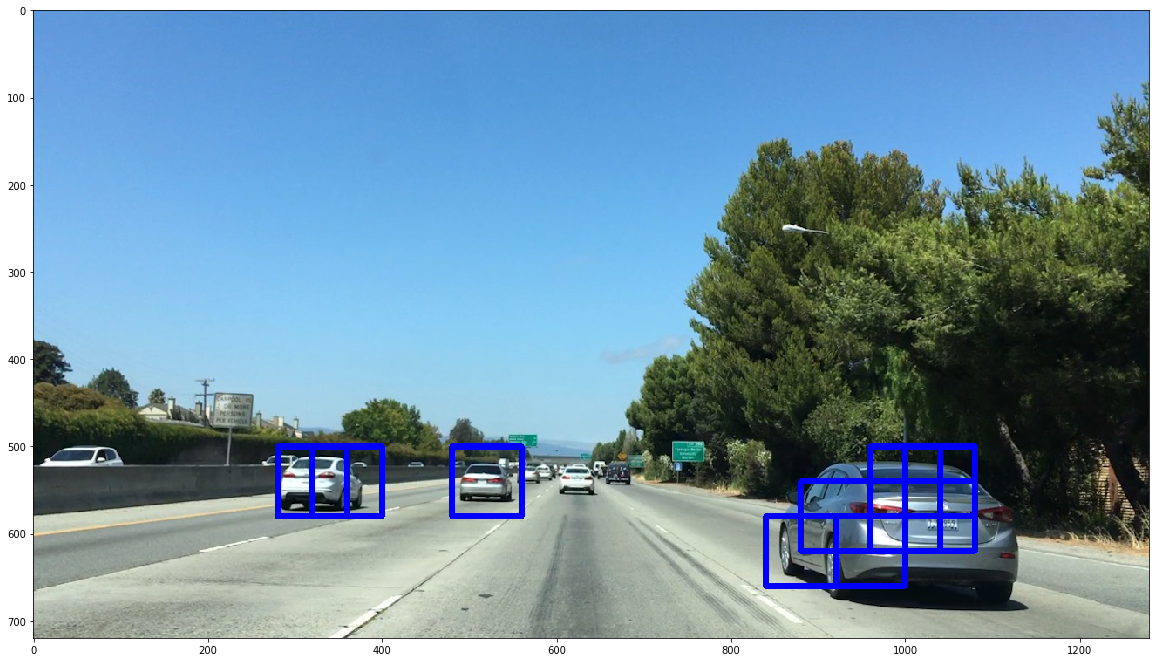

In [121]:
# Read a image
image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)


# If images is a .png (like full Dataset) correct scale thes
if Full_dataset == True:
    image = image.astype(np.float32)/255

# Extract Windows
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(80, 80), xy_overlap=(0.5, 0.5))

# Find cars in given windows (windows)
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

# Draw boxes where cars where found
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Plot result
plt.figure(figsize=(20,20))
plt.imshow(window_img)

In [122]:
# Define a function to convert color
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    bbox_list=[]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return draw_img, bbox_list
    

## Testing Parameters in Test Images

StandardScaler(copy=True, with_mean=True, with_std=True) 11 8 2 (32, 32) 64
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.3, 0.5, 1], 'kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
[((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))]


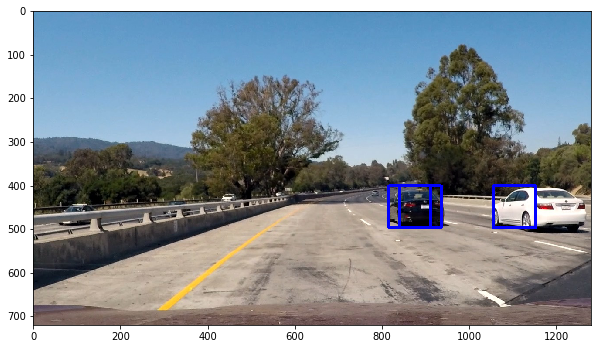

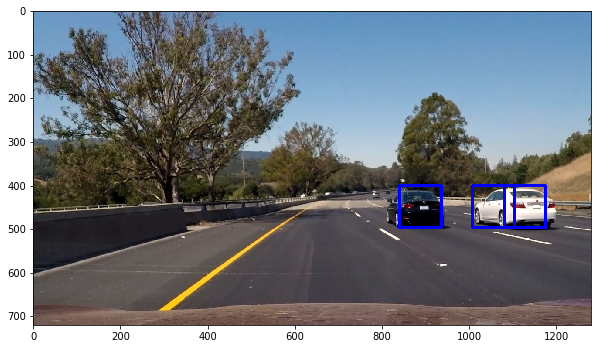

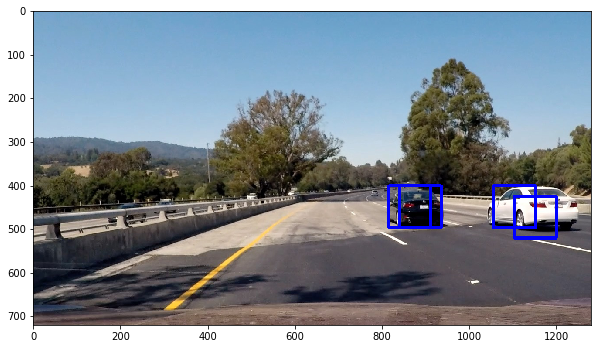

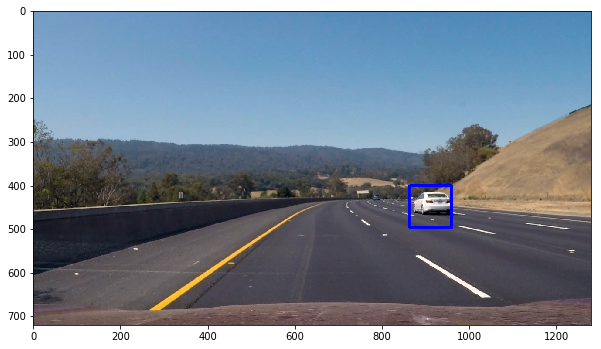

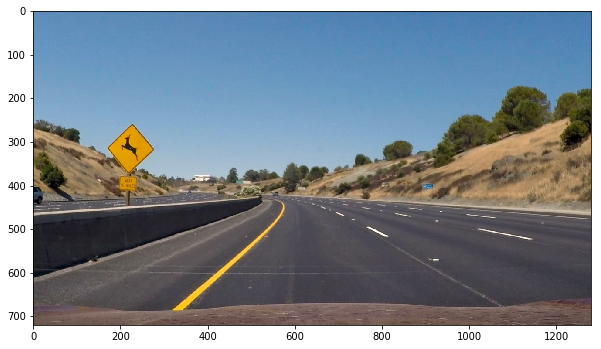

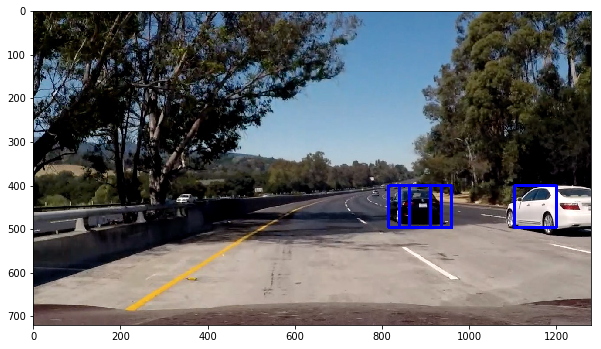

In [124]:
# Set Parametes to test
ystart = 400 # y start point
ystop = 600 # y stop point
scale = 1.5 # scale of windows

# Using glob to get a list of test images file names
test_images = glob.glob('test_images/*.jpg')

# Read each Test Image
for test in test_images:
    img = mpimg.imread(test)
    # Find Cars
    out_img, box_list = find_cars(img, ystart, ystop, scale, 
                                  svc, X_scaler, orient, pix_per_cell, 
                                  cell_per_block, spatial_size, hist_bins)
    #plt.figure(figsize=(20,20))
    plt.figure(figsize=(10,10))
    plt.imshow(out_img)
   
    

print(X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(svc)

print(box_list)

## Using a List of Parameters

Testing and definig a function to received a list of parameter and return a list of box where cars was found.

In [189]:
list_ystart = [400, 410, 400, 430, 400, 430, 400, 460]
list_ystop =  [470, 480, 500, 530, 530, 560, 600, 700]
list_scale =  [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]

In [154]:
# Creating a empty list
box_list = []

# Read a test image
img = mpimg.imread('test4.jpg')

# For each parameter in parameter lists (list_ystart, list_ystop, list_scale)
for start, stop, scale in zip( list_ystart, list_ystop, list_scale):
    
    # Look for cars
    out_img, box_temp = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    # If car was found feed box list
    if (len(box_temp) != 0):
        box_list += box_temp
    

## Results

box :  ((873, 411), (917, 455))
box :  ((1064, 411), (1108, 455))
box :  ((1075, 400), (1119, 444))
box :  ((1075, 411), (1119, 455))
box :  ((1086, 400), (1130, 444))
box :  ((1142, 422), (1186, 466))
box :  ((864, 400), (928, 464))
box :  ((880, 432), (944, 496))
box :  ((816, 400), (912, 496))
box :  ((840, 400), (936, 496))
box :  ((1056, 400), (1152, 496))
box :  ((1104, 424), (1200, 520))

Box found: 12


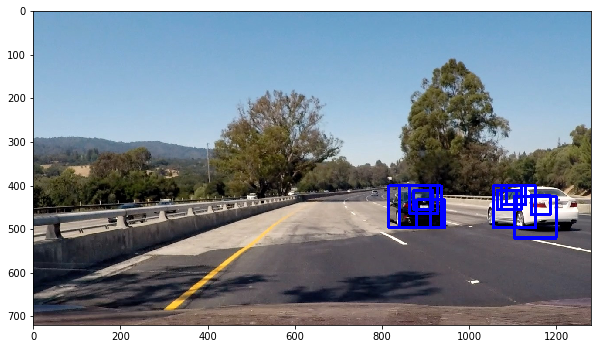

In [155]:
# Test results
out_img = draw_boxes(img, box_list)

# Plot Results
plt.figure(figsize=(10,10))
plt.imshow(out_img)

for box in box_list:
      print ("box : ", box)
        
print("\nBox found:", len(box_list))

## Defining a mutiple_scale_find_cars

Defining a optimized version of find_cars function, that get a list of parameters as argument and solve "perspective problem", in other words, cars appears smaller when they is far, and bigger when is near. So using a list of parameters our algorithm find cars using proper windows sizes in each vertical lane.

In [160]:
# Define a function to find cars in multiple windows sizes
def mutiple_scale_find_cars(img, list_ystart, list_ystop, list_scale):
    
    box_list = []
    
    # For each parameter in parameter lists (list_ystart, list_ystop, list_scale)
    for start, stop, scale in zip( list_ystart, list_ystop, list_scale):
    
        out_img, box_temp = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        # If car was found feed box list
        if (len(box_temp) != 0):
            box_list += box_temp
    
    return box_list


# Draw a Single Box and Heatmap

As we've seen in results above, our function draw many boxes if car were found more than one time, we can use that information to create a more robust method that can be able to exclude false positives and where a car were found with por confidence draw a unique box.

To indentify the number and positions of cars found in heatmap we'll use [Scipy Label Function](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html) that will give and this information.

In [156]:
# Read in image similar to one shown above 
image = mpimg.imread('test3.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Function to add "heat" in a heatmap where box were found
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Function to clean areas where possible false positives were found
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Function to Draw a single box, using scipy label function
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


2 cars found


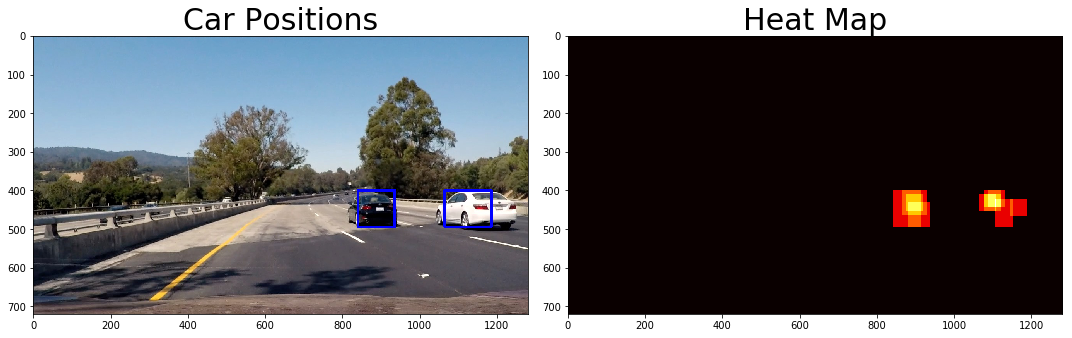

In [172]:
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

# Plot results
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=30)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=30)
fig.tight_layout()

print(labels[1], 'cars found')


#plt.savefig('output_images/heat_map1.png', bbox_inches="tight")

## Testing Pipeline

To indentify car in each image we need to perform some steps described above:

1. Read a image
2. Find Cars using multiple scale windows and get a Boxes List where they were found
3. Using a Boxes List add heat in a heatmap
4. Apply a Threshold to clean false positives
5. Using Scipy Label function "locate and count" cars found
6. Draw a single bounding box for each car found

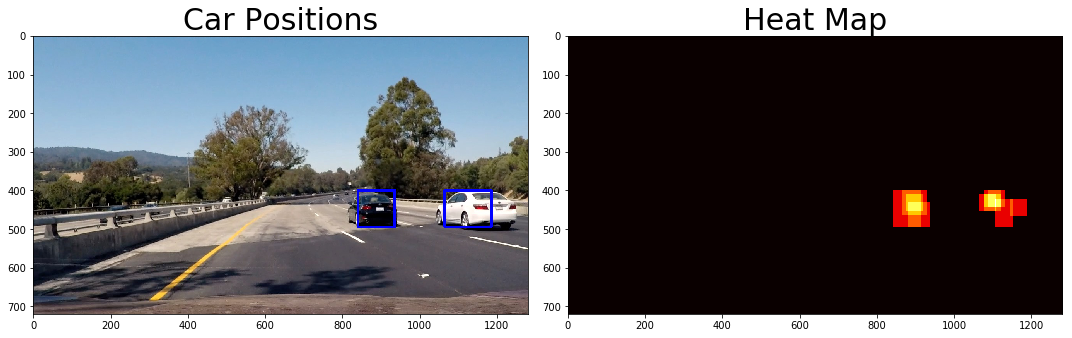

In [161]:
# Read a image
img = mpimg.imread('test4.jpg')

# Find Cars using multiple scale windows and get a Boxes List where they were found
box_list = mutiple_scale_find_cars(img, list_ystart, list_ystop, list_scale)

out_img = draw_boxes(img, box_list)


# Using a Boxes List add heat in a heatmap
heat = add_heat(heat,box_list)
    
# Apply a Threshold to clean false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# FUsing Scipy Label function "locate and count" cars found
labels = label(heatmap)

# Draw a single bounding box for each car found
draw_img = draw_labeled_bboxes(np.copy(img), labels)

# Plot Results
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=30)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=30)
fig.tight_layout()


## Define a Process_Image Function:

Get a Image, run all described pipeline and return a image with bounding boxes where cars were found.

In [166]:
def process_image(img):
    
    # Heat image like img
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Get a boxes list
    box_list = mutiple_scale_find_cars(img, list_ystart, list_ystop, list_scale)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img       
    

## Test process_image

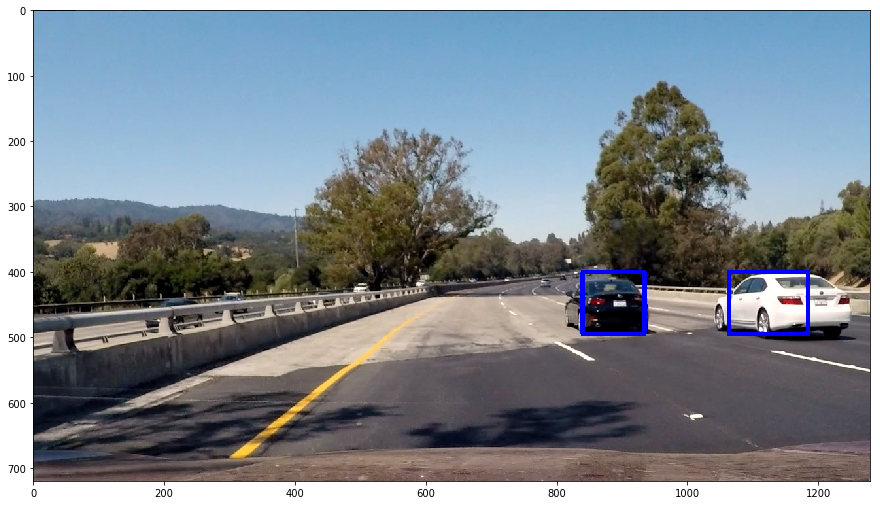

In [167]:
# Read Image
img = mpimg.imread('test4.jpg')

# Run Process Image
draw_img = process_image(img)

# Plot Result
fig = plt.figure(figsize=(15,15))
plt.imshow(draw_img)

# Find Cars on Video

In [168]:
test_output = "test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [21:22<00:33, 33.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 21min 24s, sys: 420 ms, total: 21min 24s
Wall time: 21min 24s


In [184]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

# Improving Car Detection

To create a better and smoother detection system we'll use information from previous frame to analize actual frame image, this way our result will be a lot smoother and eventual false posives that apper in only one frame will be removed.

In [9]:

# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

* Code for Class to store data from video was copied from [Je'remy Shannon's work](https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb)

In [11]:
# Define a process frame for video
def process_frame_for_video(img):
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Get boxes list    
    box_list = mutiple_scale_find_cars(img, list_ystart, list_ystop, list_scale)
    
    # add detections to the history
    if len(box_list) > 0:
        det.add_rects(box_list)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

* Code for add heat using data stored from previous frame was inspired from [Je'remy Shannon's work](https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb)

## Testing with a Single Image

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



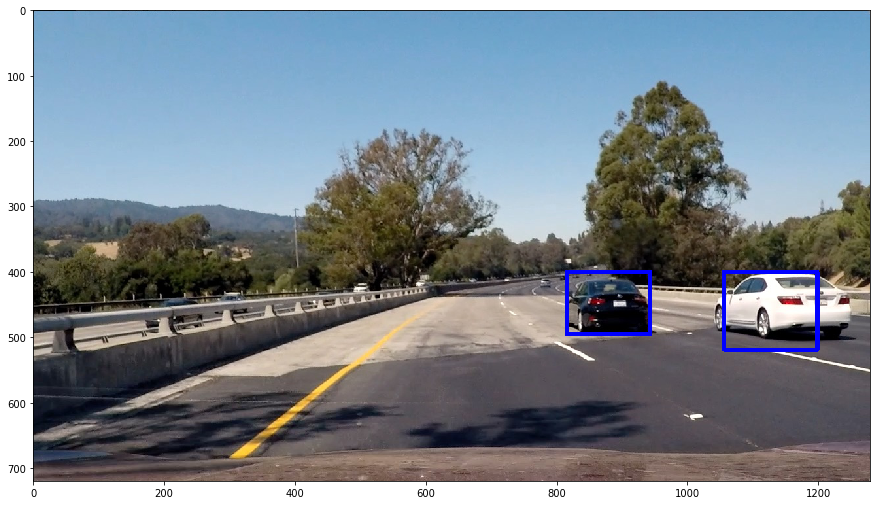

In [194]:
det = Vehicle_Detect()


imagem = process_frame_for_video(img)

fig = plt.figure(figsize=(15,15))
plt.imshow(imagem)

## Project Video

In [199]:
det = Vehicle_Detect()

project_output = "projec_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_frame_for_video)
%time test_clip.write_videofile(project_output, audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video projec_output.mp4
[MoviePy] Writing video projec_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/home/trevisan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

100%|█████████▉| 1260/1261 [9:00:26<00:25, 25.56s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: projec_output.mp4 

CPU times: user 9h 1min 56s, sys: 15.9 s, total: 9h 2min 12s
Wall time: 9h 28s


## Final Outpu

We can see that when consider information from previous frame we get better and smoother results.

In [200]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))